In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import time
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
import sklearn.metrics
import math
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor

In [326]:
x_train = pd.read_csv('x_train_full.csv')
x_val = pd.read_csv('x_val_full.csv')
x_test = pd.read_csv('x_test_full.csv')
y_train = pd.read_csv('./Data with correct player_atts/y_train.csv')
y_val = pd.read_csv('./Data with correct player_atts/y_val.csv')
y_test = pd.read_csv('./Data with correct player_atts/y_test.csv')

In [327]:
label_dict = {1:0, 0:1, -1:2 }
y_train['target'] = y_train['result'].map(label_dict)
y_val['target'] =  y_val['result'].map(label_dict)
y_test['target'] =  y_test['result'].map(label_dict)

In [288]:
## Rebalance proportion of home wins/draws/home losses
incides = y_train[y_train['result'] == 1].sample(frac = 0.35).index.values
mask_y= ~ y_train.index.isin(indices)
mask_x= ~ x_train.index.isin(indices)
y_train = y_train[mask_y]
x_train = x_train[mask_x]
assert len(x_train) == len(y_train)
assert (x_train.index == y_train.index).sum()
assert (x_train.match_api_id == y_train.match_api_id).sum()

In [329]:
min_max_scaler = preprocessing.MinMaxScaler()

x_train = pd.DataFrame(min_max_scaler.fit_transform(x_train.iloc[:,1:]), index = x_train['match_api_id'], columns = x_train.iloc[:,1:].columns)
x_val = pd.DataFrame(min_max_scaler.fit_transform(x_val.iloc[:,1:]), index = x_val['match_api_id'], columns = x_val.iloc[:,1:].columns)
x_test = pd.DataFrame(min_max_scaler.fit_transform(x_test.iloc[:,1:]), index = x_test['match_api_id'], columns = x_test.iloc[:,1:].columns)

In [330]:
y_train['result'].value_counts(normalize=True)

 1    0.458586
-1    0.289090
 0    0.252324
Name: result, dtype: float64

In [402]:
# Build Network
input_size = len(x_train.columns)
hidden_sizes = [1024,512,256,256,64,32]
output_size = 3

# Build a feed-forward network
LinearNN = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.Tanh(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                        nn.ReLU(),
                        nn.Linear(hidden_sizes[2], hidden_sizes[3]),
                        nn.ReLU(),
                         nn.Linear(hidden_sizes[3], hidden_sizes[4]),
                        nn.ReLU(),
                         nn.Linear(hidden_sizes[4], hidden_sizes[5]),
                        nn.ReLU(),
                      nn.Linear(hidden_sizes[5], output_size),
                      nn.Softmax()
                        )


In [414]:
# Hyperparameters

batch_size = 1024 #len(x_train)
epochs = 100
learning_rate = 0.001
loss = 0
losses = []
counter = 0

dataset = TensorDataset( Tensor(x_train.values), torch.Tensor(y_train['target'].values) )
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=False)

optimizer = torch.optim.Adam(LinearNN.parameters(), lr=learning_rate, betas=(0.9,0.998))

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 20 , gamma = 0.1)
mse = torch.nn.MSELoss()
cross = nn.CrossEntropyLoss()

Loss after iteration 0: 0.9887110590934753
Loss after iteration 500: 1.0094228982925415
Loss after iteration 1000: 0.980442225933075
Loss after iteration 1500: 0.969423770904541
Elapsed time: 272.39280796051025 s
0.9554762244224548


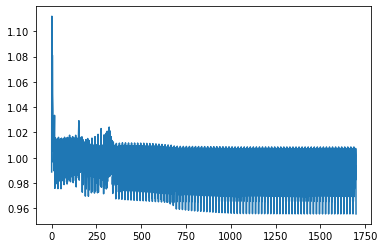

In [415]:
#Train Model

t = time.time()
for epoch in range(epochs):
    for x, y in iter(train_loader):
        LinearNN.train()
        LinearNN.zero_grad()
        
        y_pred = LinearNN(x)
        loss = cross(y_pred, y.long())
        
        if counter % 500 ==0:
            print('Loss after iteration {}: {}'.format(counter, loss.item()))
        
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        counter+=1 
    counter+=1
    scheduler.step()
time.time()-t        
        
        
print('Elapsed time: {} s'.format(time.time()-t))    
print(loss.item())  
plt.plot(range(len(losses)), losses)
plt.show()

In [417]:
##Eval 

LinearNN.eval()
with torch.no_grad():
    val_pred = LinearNN(Tensor(x_val.values))
    
y_val_pred = pd.Series(val_pred.max(1).indices).map({0:1,1:0,2:-1})
sklearn.metrics.accuracy_score(y_val_pred, y_val['result'])

0.5219378427787934

In [418]:
y_val_pred.value_counts()

 1    744
-1    350
dtype: int64

In [409]:
y_pred

tensor([[5.9356e-03, 3.0736e-03, 9.9099e-01],
        [4.1059e-01, 2.2425e-01, 3.6516e-01],
        [2.0131e-02, 1.1838e-02, 9.6803e-01],
        [1.2093e-01, 7.8236e-02, 8.0084e-01],
        [9.9939e-01, 5.0194e-04, 1.0468e-04],
        [3.4292e-01, 1.9998e-01, 4.5710e-01],
        [3.2567e-02, 1.9979e-02, 9.4745e-01],
        [9.8265e-01, 1.2221e-02, 5.1297e-03],
        [9.7054e-01, 2.0058e-02, 9.4000e-03],
        [1.0509e-01, 6.7384e-02, 8.2753e-01],
        [5.3032e-01, 2.2325e-01, 2.4643e-01],
        [9.3053e-01, 4.4439e-02, 2.5035e-02],
        [3.3721e-01, 1.9663e-01, 4.6615e-01],
        [9.9836e-01, 1.3036e-03, 3.3465e-04],
        [7.2061e-01, 1.5381e-01, 1.2558e-01],
        [6.4069e-03, 3.3460e-03, 9.9025e-01],
        [4.5926e-01, 2.3473e-01, 3.0600e-01],
        [9.9326e-01, 5.0133e-03, 1.7291e-03],
        [2.8871e-01, 1.7453e-01, 5.3677e-01],
        [9.9922e-01, 6.4005e-04, 1.4074e-04],
        [3.9021e-02, 2.4143e-02, 9.3684e-01],
        [9.9038e-01, 7.0139e-03, 2